In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms 

In [2]:
#!pip install --upgrade albumentations --user

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

In [4]:

# loading the dataset
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(exp_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(exp_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(exp_data, axis=(0,1,2)) / 255.)

Files already downloaded and verified
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [5]:
classes= exp.classes

In [6]:
def vizualize_data(cols=8, rows=5):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = exp[i]

    figure.add_subplot(rows, cols, i)
    plt.title(exp.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

    plt.tight_layout()
plt.show()

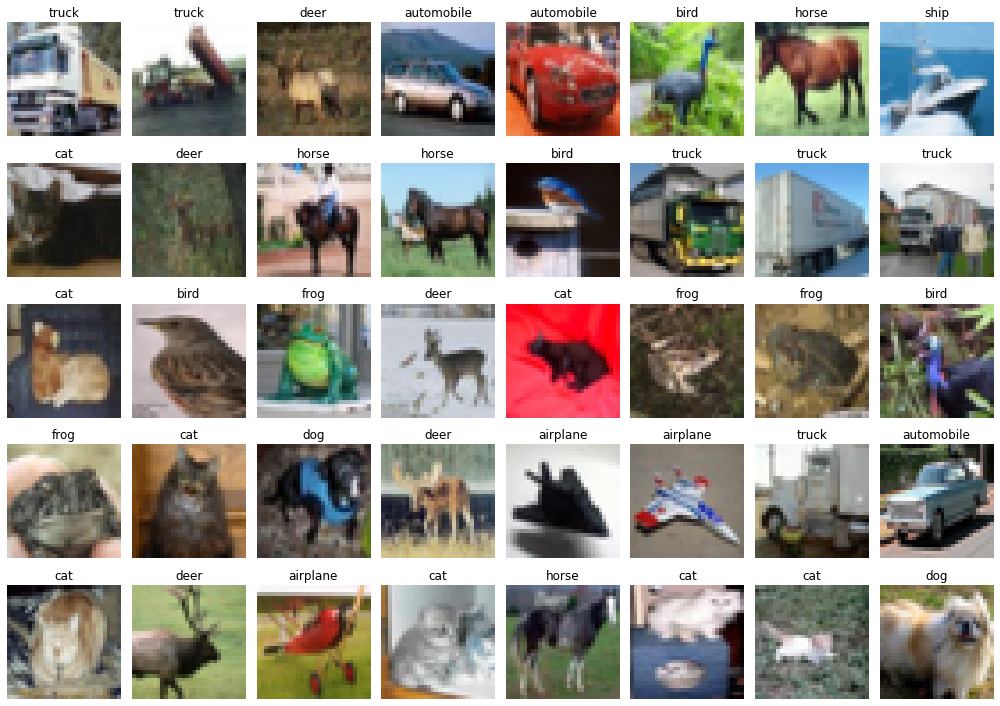

In [7]:
vizualize_data()

In [8]:
def show_images(aug_dict, ncol=6):
    nrow = len(aug_dict)

    fig, axes = plt.subplots(ncol, nrow, figsize=( 3*nrow, 15), squeeze=False)
    for i, (key, aug) in enumerate(aug_dict.items()):
        for j in range(ncol):
            ax = axes[j,i]
            if j == 0:
                ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.axis('off')
            else:
                image, label = exp[j-1]
                if aug is not None:
                    transform = A.Compose([aug])
                    image = np.array(image)
                    image = transform(image=image)['image']
          
                ax.imshow(image)
                ax.set_title(f'{exp.classes[label]}')
                ax.axis('off')
    plt.tight_layout()
    plt.show()


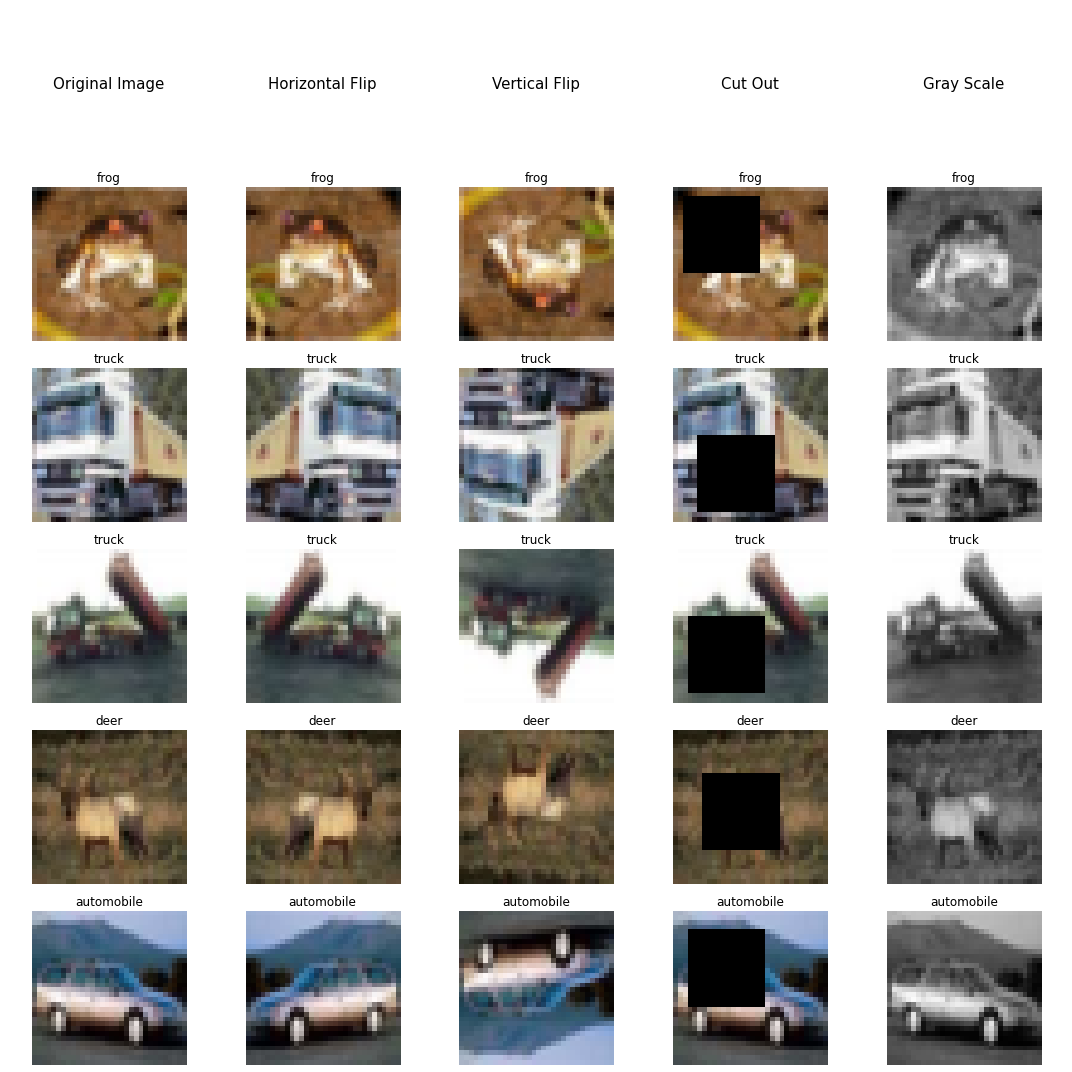

In [9]:
show_images({
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

In [10]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                                       ])

In [11]:
trainset =datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform= train_transforms )
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform= test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


In [13]:
print(len(train_loader))

782


In [14]:
import torch.nn as nn
import torch.nn.functional as F
class Model_3(nn.Module):
    def __init__(self, drop=0.025):
        super(Model_3, self).__init__()

        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3), padding= 1, bias=False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(drop),)
        
        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3),padding= 1, bias=False),   # Input: 32x32x32 | Output: 32x32x32 | RF: 5x5
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(drop),)
        
        self.convblock1c = nn.Sequential(    
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3),padding= 1, bias=False),   # Input: 32x32x32 | Output: 32x32x32 | RF: 5x5
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.transblock1 =  nn.Sequential(
            #Stride 2 conv
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), bias=False),  # Input: 32x32x32 | Output: 16x16x32 | RF: 7x7
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Dropout(drop),

        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock2a = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3),padding= 1, bias=False),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(drop))
        
        self.convblock2b  = nn.Sequential( 
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding= 1, bias=False),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(drop)) 
            
        self.convblock2c  = nn.Sequential(  
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3, 3), bias=False),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),  
    
        ) 

        self.transblock2 =  nn.Sequential(
            #Stride 2 conv
            #DepthwiseSeparable(64,64,2), # Input: 16x16x64 | Output: 8x8x64 | RF: 15x15
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), bias=False),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            ##nn.Dropout(drop),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock3a = nn.Sequential(          
            nn.Conv2d(in_channels=16, out_channels=40, kernel_size=(3, 3), bias=False),
            nn.LayerNorm([40,5,5]),
            nn.ReLU(),
            nn.Dropout(drop))
        
        self.convblock3b=nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(3, 3),padding =1, bias=False), # Input: 8x8x128 | Output: 8x8x32 | RF: 23x23
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Dropout(drop) 

        ) 
        self.transblock3 =  nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), bias=False), # Input: 8x8x128 | Output: 6x6x32 | RF: 39x39
            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False), # Input: 6x6x32 | Output: 4x4x32 | RF: 55x55
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Dropout(drop),
        )

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x =  self.convblock1a(x)
        x =  self.convblock1b(x)
        x =  self.convblock1c(x)
        x =  self.transblock1(x)
        x =  self.pool1(x)
        x =  self.convblock2a(x)
        x =  self.convblock2b(x)
        x =  self.convblock2c(x)
        x =  self.transblock2(x)
        x =  self.pool2(x)
        x =  self.convblock3a(x)
        x =  self.convblock3b(x)
        x =  self.transblock3(x)
        x= self.global_avgpool(x)     
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [15]:
import torch.nn as nn
import torch.nn.functional as F
class Model_3(nn.Module):
    def __init__(self, drop=0.025):
        super(Model_3, self).__init__()

        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3), padding= 1, bias=False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(drop),)
        
        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3),padding= 1, bias=False),   # Input: 32x32x32 | Output: 32x32x32 | RF: 5x5
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(drop),)
        
        self.convblock1c = nn.Sequential(    
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3),padding= 1, bias=False),   # Input: 32x32x32 | Output: 32x32x32 | RF: 5x5
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.transblock1 =  nn.Sequential(
            #Stride 2 conv
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), bias=False),  # Input: 32x32x32 | Output: 16x16x32 | RF: 7x7
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Dropout(drop),

        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock2a = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),padding= 1, bias=False, ),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            #nn.BatchNorm2d(12),
            nn.LayerNorm([12,16,16]),
            nn.ReLU(),
            nn.Dropout(drop))
        
        self.convblock2b  = nn.Sequential( 
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding= 1, bias=False),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(24), #nn.LayerNorm([24,5,5])
            nn.ReLU(),
            nn.Dropout(drop)) 
            
        self.convblock2c  = nn.Sequential(  
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3, 3), bias=False),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),  
    
        ) 

        self.transblock2 =  nn.Sequential(
            #Stride 2 conv
            #DepthwiseSeparable(64,64,2), # Input: 16x16x64 | Output: 8x8x64 | RF: 15x15
            nn.Conv2d(in_channels=32, out_channels=20, kernel_size=(1, 1), bias=False),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            ##nn.Dropout(drop),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock3a = nn.Sequential(          
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), stride =2, bias=False),
            #nn.BatchNorm2d(24),
            nn.LayerNorm([32,3,3]),
            nn.ReLU(),
            nn.Dropout(drop))
        
        self.convblock3b=nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),padding =1, bias=False), # Input: 8x8x128 | Output: 8x8x32 | RF: 23x23
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop) 

        ) 
        self.transblock3 =  nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), bias=False), # Input: 8x8x128 | Output: 6x6x32 | RF: 39x39
            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False), # Input: 6x6x32 | Output: 4x4x32 | RF: 55x55
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Dropout(drop),
        )

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x =  self.convblock1a(x)
        x =  self.convblock1b(x)
        x =  self.convblock1c(x)+x
        x =  self.transblock1(x)
        x =  self.pool1(x)
        x =  self.convblock2a(x)
        x =  self.convblock2b(x)
        x =  self.convblock2c(x)
        x =  self.transblock2(x)
        x =  self.pool2(x)
        x =  self.convblock3a(x)
        x =  self.convblock3b(x)+x
        x =  self.transblock3(x)
        x= self.global_avgpool(x)     
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [16]:
#dropout_value = 0.1
#from model import Model_3
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_3().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             324
       BatchNorm2d-2           [-1, 12, 32, 32]              24
              ReLU-3           [-1, 12, 32, 32]               0
           Dropout-4           [-1, 12, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           2,592
       BatchNorm2d-6           [-1, 24, 32, 32]              48
              ReLU-7           [-1, 24, 32, 32]               0
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9           [-1, 24, 32, 32]           5,184
      BatchNorm2d-10           [-1, 24, 32, 32]              48
             ReLU-11           [-1, 24, 32, 32]               0
          Dropout-12           [-1, 24, 32, 32]               0
           Conv2d-13           [-1, 12, 32, 32]             288
        MaxPool2d-14           [-1

In [17]:
print(len(train_loader))
print(len(test_loader))

782
157


In [18]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [19]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    
    print('\nTrain set: Train loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
from torch.optim.lr_scheduler import StepLR
model = Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size =4, gamma =0.3)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


loss=1.568773627281189 batch_id=781: 100%|███████████████████████████████████████████| 782/782 [00:51<00:00, 15.10it/s]



Train set: Train loss: 1308.9268, Train Accuracy: 18502/50000 (37.00%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4344, Accuracy: 4554/10000 (45.54%)

EPOCH: 1


loss=1.108500599861145 batch_id=781: 100%|███████████████████████████████████████████| 782/782 [00:50<00:00, 15.43it/s]



Train set: Train loss: 1067.1291, Train Accuracy: 25253/50000 (50.51%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4397, Accuracy: 4785/10000 (47.85%)

EPOCH: 2


loss=1.5059093236923218 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:49<00:00, 15.94it/s]



Train set: Train loss: 977.3365, Train Accuracy: 27425/50000 (54.85%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1749, Accuracy: 5810/10000 (58.10%)

EPOCH: 3


loss=1.3720436096191406 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:48<00:00, 15.98it/s]



Train set: Train loss: 931.5166, Train Accuracy: 28547/50000 (57.09%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1103, Accuracy: 5975/10000 (59.75%)

EPOCH: 4


loss=0.9015898108482361 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:48<00:00, 16.19it/s]



Train set: Train loss: 856.7247, Train Accuracy: 30245/50000 (60.49%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0328, Accuracy: 6301/10000 (63.01%)

EPOCH: 5


loss=1.5656267404556274 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:48<00:00, 16.02it/s]



Train set: Train loss: 840.1284, Train Accuracy: 30804/50000 (61.61%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0001, Accuracy: 6372/10000 (63.72%)

EPOCH: 6


loss=1.2020971775054932 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:48<00:00, 16.21it/s]



Train set: Train loss: 827.3232, Train Accuracy: 31002/50000 (62.00%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9831, Accuracy: 6454/10000 (64.54%)

EPOCH: 7


loss=1.355547547340393 batch_id=781: 100%|███████████████████████████████████████████| 782/782 [00:49<00:00, 15.69it/s]



Train set: Train loss: 822.1966, Train Accuracy: 31180/50000 (62.36%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9502, Accuracy: 6596/10000 (65.96%)

EPOCH: 8


loss=1.3969475030899048 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:49<00:00, 15.67it/s]



Train set: Train loss: 796.2322, Train Accuracy: 31818/50000 (63.64%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9421, Accuracy: 6597/10000 (65.97%)

EPOCH: 9


loss=1.12751042842865 batch_id=781: 100%|████████████████████████████████████████████| 782/782 [00:48<00:00, 16.01it/s]



Train set: Train loss: 790.5910, Train Accuracy: 31827/50000 (63.65%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9195, Accuracy: 6683/10000 (66.83%)

EPOCH: 10


loss=0.6551623940467834 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:50<00:00, 15.49it/s]



Train set: Train loss: 786.6489, Train Accuracy: 31952/50000 (63.90%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9184, Accuracy: 6672/10000 (66.72%)

EPOCH: 11


loss=1.7180067300796509 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:49<00:00, 15.79it/s]



Train set: Train loss: 786.2651, Train Accuracy: 31968/50000 (63.94%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9382, Accuracy: 6589/10000 (65.89%)

EPOCH: 12


loss=1.1140803098678589 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:50<00:00, 15.56it/s]



Train set: Train loss: 772.9661, Train Accuracy: 32296/50000 (64.59%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9089, Accuracy: 6699/10000 (66.99%)

EPOCH: 13


loss=1.003919005393982 batch_id=781: 100%|███████████████████████████████████████████| 782/782 [00:50<00:00, 15.62it/s]



Train set: Train loss: 771.0986, Train Accuracy: 32402/50000 (64.80%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9092, Accuracy: 6702/10000 (67.02%)

EPOCH: 14


loss=1.0915510654449463 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:49<00:00, 15.80it/s]



Train set: Train loss: 774.1718, Train Accuracy: 32348/50000 (64.70%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9079, Accuracy: 6694/10000 (66.94%)

EPOCH: 15


loss=0.6675799489021301 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:49<00:00, 15.85it/s]



Train set: Train loss: 769.1315, Train Accuracy: 32317/50000 (64.63%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9201, Accuracy: 6701/10000 (67.01%)

EPOCH: 16


loss=1.0468158721923828 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:50<00:00, 15.59it/s]



Train set: Train loss: 763.9238, Train Accuracy: 32517/50000 (65.03%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9136, Accuracy: 6677/10000 (66.77%)

EPOCH: 17


loss=1.4238080978393555 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:50<00:00, 15.46it/s]



Train set: Train loss: 764.0550, Train Accuracy: 32513/50000 (65.03%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8981, Accuracy: 6724/10000 (67.24%)

EPOCH: 18


loss=0.8749369978904724 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:49<00:00, 15.65it/s]



Train set: Train loss: 766.7052, Train Accuracy: 32446/50000 (64.89%)



  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9063, Accuracy: 6703/10000 (67.03%)

EPOCH: 19


loss=1.5543934106826782 batch_id=781: 100%|██████████████████████████████████████████| 782/782 [00:50<00:00, 15.59it/s]



Train set: Train loss: 764.5382, Train Accuracy: 32463/50000 (64.93%)


Test set: Average loss: 0.9055, Accuracy: 6714/10000 (67.14%)



Text(0.5, 1.0, 'Loss per epoch')

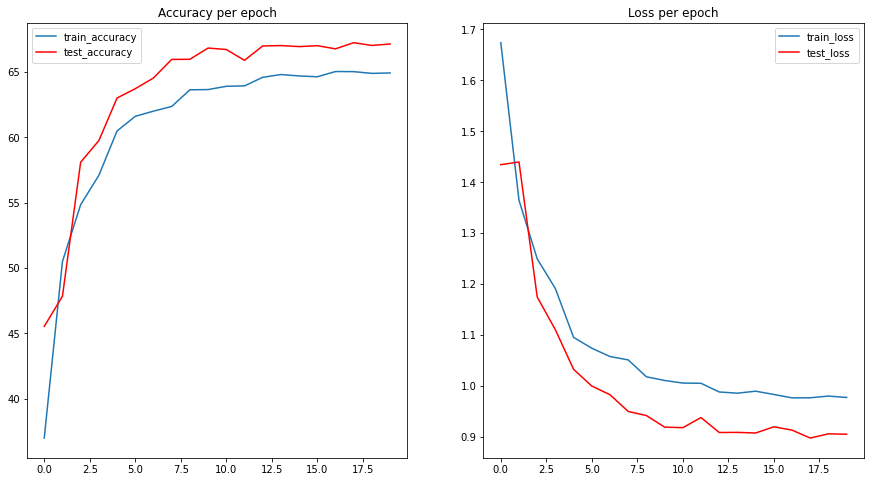

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_acc))
plt.plot(np.array(test_acc), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_losses)
plt.plot(test_losses, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")

In [22]:
exp = datasets.CIFAR10('./data', train=True, download=True)
classes= exp.classes

Files already downloaded and verified


In [23]:

from pylab import *

def getWrongPredictions(model, device, val_loader):
    wrong_idx = []
    wrong_samples = []
    wrong_preds = []
    actual_values = []

    for data,target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
        wrong_samples.append(data[wrong_idx])
        wrong_preds.append(pred[wrong_idx])
        actual_values.append(target.view_as(pred)[wrong_idx])
    return list(zip(torch.cat(wrong_samples),torch.cat(wrong_preds),torch.cat(actual_values)))

def plotWrongPredictions(wrong_predictions):
    fig = plt.figure(figsize=(10,10))
    mean,std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    for i, (sample, wrong_pred, actual_value) in enumerate(wrong_predictions[:20]):
        sample, wrong_pred, actual_value = sample.cpu().numpy(), wrong_pred.cpu(), actual_value.cpu()
        # Undo normalization
        for j in range(sample.shape[0]):
            sample[j] = (sample[j]*std[j])+mean[j]
        sample = np.transpose(sample, (1, 2, 0))
        ax = fig.add_subplot(4, 5, i+1)
        ax.axis('off')
        ax.set_title(f'actual {classes[actual_value.item()]}\npredicted {classes[wrong_pred.item()]}',fontsize=15)
        ax.imshow(sample)
    plt.show()
def imshow(img,c = "" ):    
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

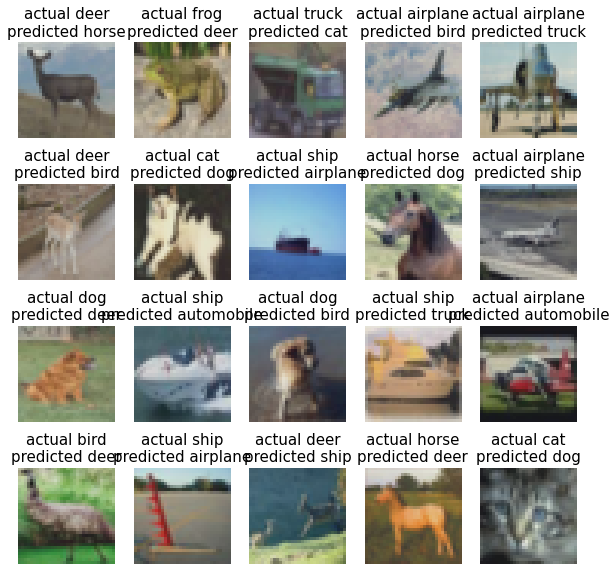

In [24]:
wp = getWrongPredictions(model, device, test_loader)
plotWrongPredictions(wp)

In [25]:

#net = net.to(device)
model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = testset.classes
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
     

Accuracy of airplane : 71 %
Accuracy of automobile : 82 %
Accuracy of  bird : 58 %
Accuracy of   cat : 38 %
Accuracy of  deer : 55 %
Accuracy of   dog : 68 %
Accuracy of  frog : 69 %
Accuracy of horse : 66 %
Accuracy of  ship : 80 %
Accuracy of truck : 81 %
